importing the librarries and loading the dataset and making 3d array of 299, 100 , 3 that is 299 samples conatining each 100 rows and 6 cols

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical

from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = "/content/drive/MyDrive/sensor_data"
FEATURES = ['LinearAccelerationX', 'LinearAccelerationY', 'LinearAccelerationZ', 'GyroscopeX', 'GyroscopeY', 'GyroscopeZ']
MAX_ROWS = 100

def load_dataset(data_dir):
    X, y = [], []
    scaler = StandardScaler()

    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        for file in os.listdir(label_path):
            if file.endswith(".csv"):
                df = pd.read_csv(os.path.join(label_path, file))[FEATURES]
                df = df.iloc[10:].reset_index(drop=True)  # Trim first 10 rows

                if len(df) < MAX_ROWS:
                    pad = pd.DataFrame(np.zeros((MAX_ROWS - len(df), len(FEATURES))), columns=FEATURES)
                    df = pd.concat([df, pad], ignore_index=True)
                else:
                    df = df.iloc[:MAX_ROWS]

                df_scaled = scaler.fit_transform(df)
                X.append(df_scaled)
                y.append(label)

    return np.array(X), np.array(y)

X, y = load_dataset(DATA_DIR)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

print("✅ Data Loaded:", X.shape, y_onehot.shape)


Mounted at /content/drive
✅ Data Loaded: (299, 100, 6) (299, 3)


building the lstm model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.5),
        LSTM(64),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


building the cnn model

In [30]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


flattening the 3d into 2d for random forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

# Flatten time series to tabular format
X_rf = X.reshape((X.shape[0], -1))  # shape: (samples, time × features)


uses k stratified fold method to find accuraccies across all model

In [38]:
def train_and_evaluate_model(build_fn, model_name, X, y, use_onehot=True):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold = 1
    acc_scores = []

    for train_idx, val_idx in kf.split(X, y_encoded):
        print(f"\n🔁 {model_name} - Fold {fold}")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train_raw, y_val_raw = y_encoded[train_idx], y_encoded[val_idx]

        if use_onehot:
            y_train = to_categorical(y_train_raw)
            y_val = to_categorical(y_val_raw)
            model = build_fn(X.shape[1:], y_train.shape[1])
            model.fit(X_train, y_train, validation_data=(X_val, y_val),
                      epochs=20, batch_size=32, verbose=0)
            y_pred = np.argmax(model.predict(X_val), axis=1)
        else:
            model = build_fn()
            model.fit(X_train, y_train_raw)
            y_pred = model.predict(X_val)

        acc = accuracy_score(y_val_raw, y_pred)
        acc_scores.append(acc)
        print(f"✅ Accuracy: {acc:.4f}")
        print(classification_report(y_val_raw, y_pred, target_names=label_encoder.classes_))

        cm = confusion_matrix(y_val_raw, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_,
                    yticklabels=label_encoder.classes_, cmap='Blues')
        plt.title(f"{model_name} - Fold {fold} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        fold += 1

    print(f"\n📊 {model_name} Average Accuracy: {np.mean(acc_scores):.4f}")



🔁 LSTM - Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
✅ Accuracy: 0.9833
              precision    recall  f1-score   support

        left       0.95      1.00      0.98        20
         mid       1.00      0.95      0.97        20
       right       1.00      1.00      1.00        20

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



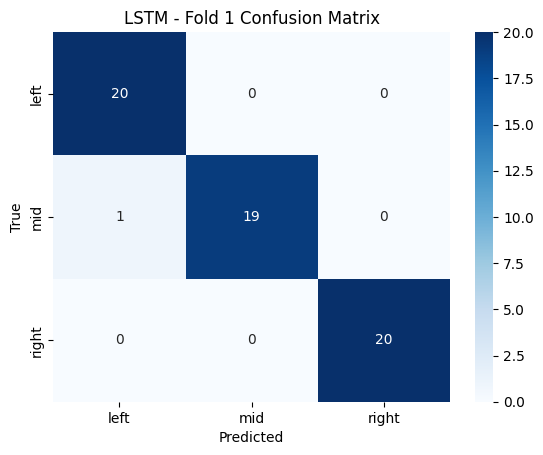


🔁 LSTM - Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
✅ Accuracy: 0.9833
              precision    recall  f1-score   support

        left       1.00      0.95      0.97        20
         mid       0.95      1.00      0.98        20
       right       1.00      1.00      1.00        20

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



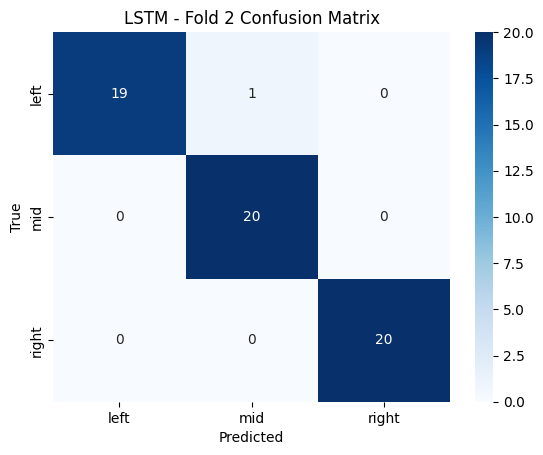


🔁 LSTM - Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
✅ Accuracy: 0.9500
              precision    recall  f1-score   support

        left       0.87      1.00      0.93        20
         mid       1.00      0.85      0.92        20
       right       1.00      1.00      1.00        20

    accuracy                           0.95        60
   macro avg       0.96      0.95      0.95        60
weighted avg       0.96      0.95      0.95        60



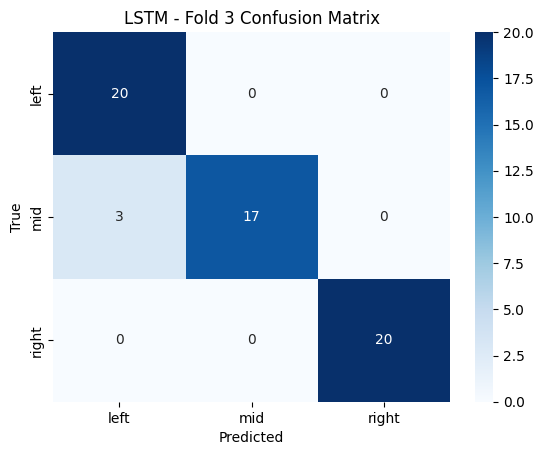


🔁 LSTM - Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
✅ Accuracy: 0.9833
              precision    recall  f1-score   support

        left       1.00      1.00      1.00        20
         mid       1.00      0.95      0.97        20
       right       0.95      1.00      0.98        20

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



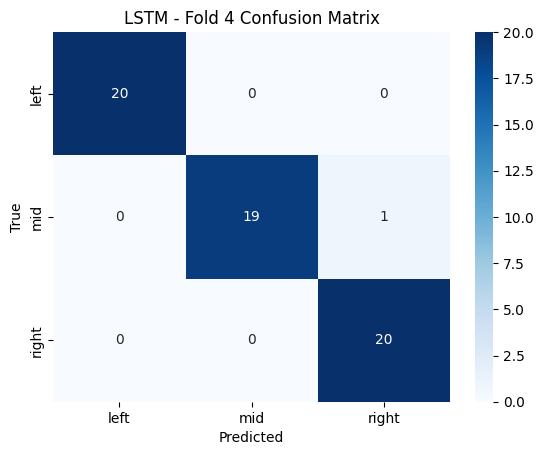


🔁 LSTM - Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
train_and_evaluate_model(build_lstm_model, "LSTM", X, y_onehot)
train_and_evaluate_model(build_cnn_model, "1D-CNN", X, y_onehot)

# Random Forest uses flattened input
train_and_evaluate_model(
    build_fn=lambda: RandomForestClassifier(n_estimators=100),
    model_name="Random Forest",
    X=X_rf,
    y=y_encoded,
    use_onehot=False
)


In [35]:
# code to test the models
def predict_csv(file_path, model, model_type='lstm'):
    df = pd.read_csv(file_path)[FEATURES]
    df = df.iloc[10:].reset_index(drop=True)

    if len(df) < MAX_ROWS:
        pad = pd.DataFrame(np.zeros((MAX_ROWS - len(df), len(FEATURES))), columns=FEATURES)
        df = pd.concat([df, pad], ignore_index=True)
    else:
        df = df.iloc[:MAX_ROWS]

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    if model_type == 'rf':
        X_input = df_scaled.reshape(1, -1)
        pred = model.predict(X_input)
    else:
        X_input = np.expand_dims(df_scaled, axis=0)
        pred = np.argmax(model.predict(X_input), axis=1)

    label = label_encoder.inverse_transform(pred)[0]
    print(f"{os.path.basename(file_path)} ➜ {label}")


In [36]:
predict_csv("content/drive/MyDrive/test_data", build_lstm_model())

TypeError: build_lstm_model() missing 2 required positional arguments: 'input_shape' and 'num_classes'

# Training 3 Models Again on more and variable data

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import joblib

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = "/content/drive/MyDrive/sensor_data"
FEATURES = ['LinearAccelerationX', 'LinearAccelerationY', 'LinearAccelerationZ', 'GyroscopeX', 'GyroscopeY', 'GyroscopeZ']
MAX_ROWS = 100

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_dataset(data_dir):
    X, y = [], []
    scaler = StandardScaler()

    for label in os.listdir(data_dir):
        for file in os.listdir(os.path.join(data_dir, label)):
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(data_dir, label, file))

                if len(df) < MAX_ROWS:
                    pad = pd.DataFrame(np.zeros((MAX_ROWS - len(df), len(FEATURES))), columns=FEATURES)
                    df = pd.concat([df, pad], ignore_index=True)
                else:
                    df = df.iloc[:MAX_ROWS]

                df_scaled = scaler.fit_transform(df)
                X.append(df_scaled)
                y.append(label)

    return np.array(X), np.array(y)

X, y = load_dataset(DATA_DIR)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

X_rf = X.reshape((X.shape[0], -1))  # Flattened for Random Forest


In [ ]:
def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.5),
        LSTM(64),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def train_and_evaluate_model(build_fn, model_name, X, y, use_onehot=True):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    acc_scores = []
    fold = 1

    for train_idx, val_idx in skf.split(X, y_encoded):
        print(f"\n🔁 {model_name} - Fold {fold}")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train_raw, y_val_raw = y_encoded[train_idx], y_encoded[val_idx]

        if use_onehot:
            y_train = to_categorical(y_train_raw)
            y_val = to_categorical(y_val_raw)
            model = build_fn(X.shape[1:], y_train.shape[1])
            model.fit(X_train, y_train, validation_data=(X_val, y_val),
                      epochs=20, batch_size=32, verbose=0,
                      callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])
            y_pred = np.argmax(model.predict(X_val), axis=1)
            model.save(f"{model_name.lower().replace(' ', '_')}_fold{fold}.h5")
        else:
            model = build_fn()
            model.fit(X_train, y_train_raw)
            y_pred = model.predict(X_val)
            joblib.dump(model, f"{model_name.lower().replace(' ', '_')}_fold{fold}.joblib")

        acc = accuracy_score(y_val_raw, y_pred)
        acc_scores.append(acc)
        print(f"✅ Accuracy: {acc:.4f}")
        print(classification_report(y_val_raw, y_pred, target_names=label_encoder.classes_))

        cm = confusion_matrix(y_val_raw, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_,
                    yticklabels=label_encoder.classes_, cmap="Blues")
        plt.title(f"{model_name} - Fold {fold}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        fold += 1

    print(f"\n📊 {model_name} Avg Accuracy: {np.mean(acc_scores):.4f}")



🔁 LSTM - Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


✅ Accuracy: 0.9918
              precision    recall  f1-score   support

        left       0.98      1.00      0.99        41
         mid       1.00      0.97      0.99        40
       right       1.00      1.00      1.00        41

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122



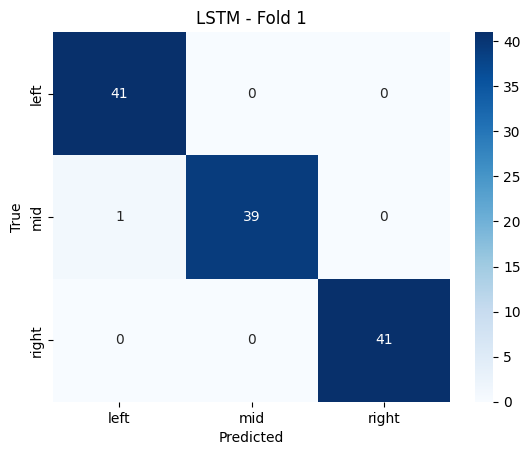


🔁 LSTM - Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


✅ Accuracy: 0.9426
              precision    recall  f1-score   support

        left       0.95      0.90      0.93        41
         mid       0.89      0.97      0.93        40
       right       1.00      0.95      0.97        41

    accuracy                           0.94       122
   macro avg       0.95      0.94      0.94       122
weighted avg       0.95      0.94      0.94       122



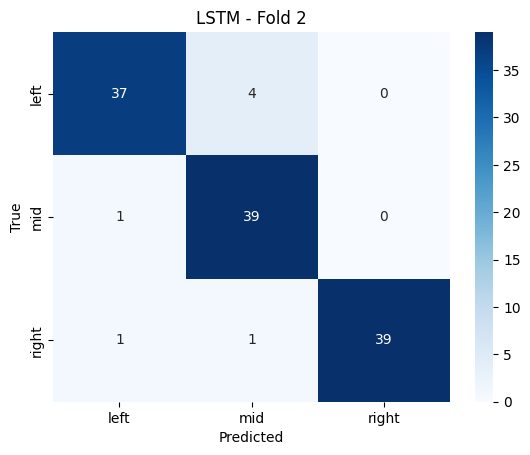


🔁 LSTM - Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


✅ Accuracy: 0.9669
              precision    recall  f1-score   support

        left       0.95      0.95      0.95        41
         mid       0.95      0.95      0.95        39
       right       1.00      1.00      1.00        41

    accuracy                           0.97       121
   macro avg       0.97      0.97      0.97       121
weighted avg       0.97      0.97      0.97       121



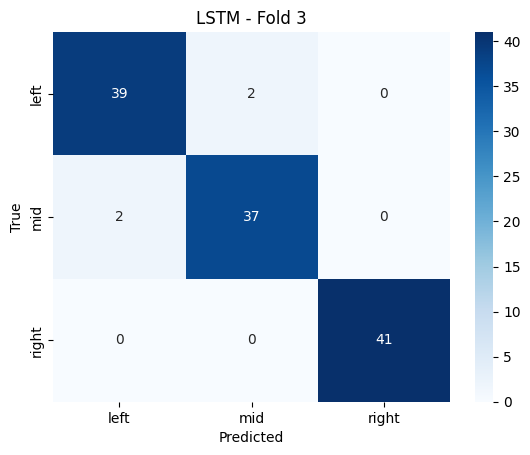


🔁 LSTM - Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


✅ Accuracy: 0.9917
              precision    recall  f1-score   support

        left       0.98      1.00      0.99        41
         mid       1.00      0.97      0.99        40
       right       1.00      1.00      1.00        40

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121



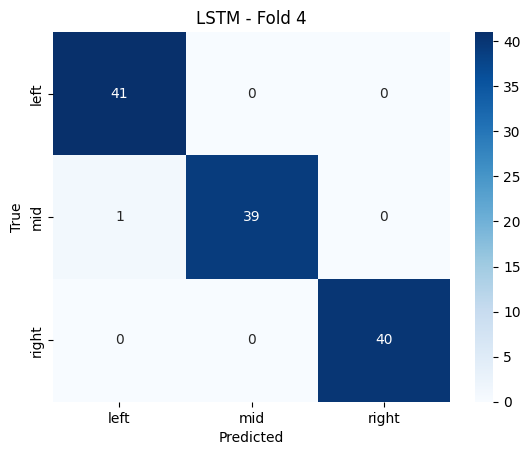


🔁 LSTM - Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


✅ Accuracy: 0.9835
              precision    recall  f1-score   support

        left       0.98      0.98      0.98        41
         mid       0.97      0.97      0.97        40
       right       1.00      1.00      1.00        40

    accuracy                           0.98       121
   macro avg       0.98      0.98      0.98       121
weighted avg       0.98      0.98      0.98       121



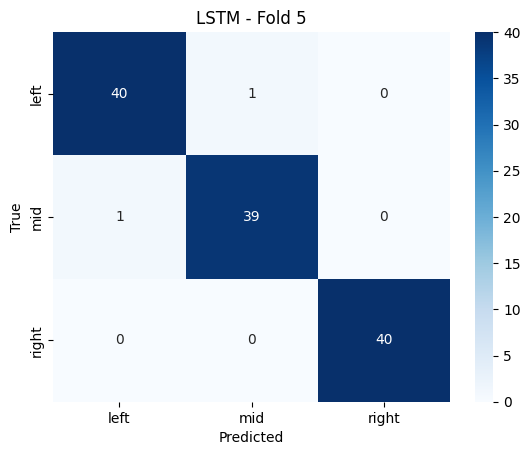


📊 LSTM Avg Accuracy: 0.9753

🔁 1D-CNN - Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


✅ Accuracy: 0.9836
              precision    recall  f1-score   support

        left       1.00      0.98      0.99        41
         mid       0.97      0.97      0.97        40
       right       0.98      1.00      0.99        41

    accuracy                           0.98       122
   macro avg       0.98      0.98      0.98       122
weighted avg       0.98      0.98      0.98       122



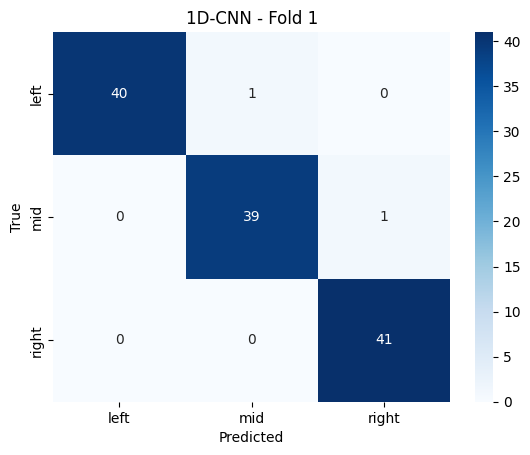


🔁 1D-CNN - Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


✅ Accuracy: 0.9754
              precision    recall  f1-score   support

        left       0.95      0.98      0.96        41
         mid       0.97      0.95      0.96        40
       right       1.00      1.00      1.00        41

    accuracy                           0.98       122
   macro avg       0.98      0.98      0.98       122
weighted avg       0.98      0.98      0.98       122



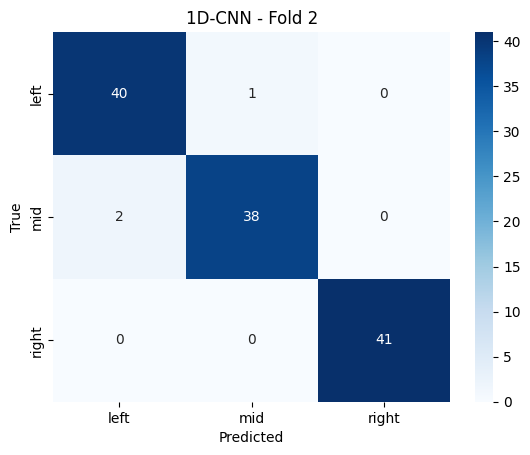


🔁 1D-CNN - Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


✅ Accuracy: 0.9917
              precision    recall  f1-score   support

        left       1.00      0.98      0.99        41
         mid       0.97      1.00      0.99        39
       right       1.00      1.00      1.00        41

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121



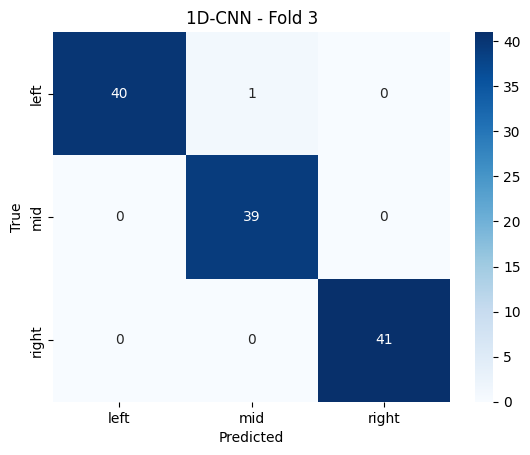


🔁 1D-CNN - Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


✅ Accuracy: 0.9917
              precision    recall  f1-score   support

        left       0.98      1.00      0.99        41
         mid       1.00      0.97      0.99        40
       right       1.00      1.00      1.00        40

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121



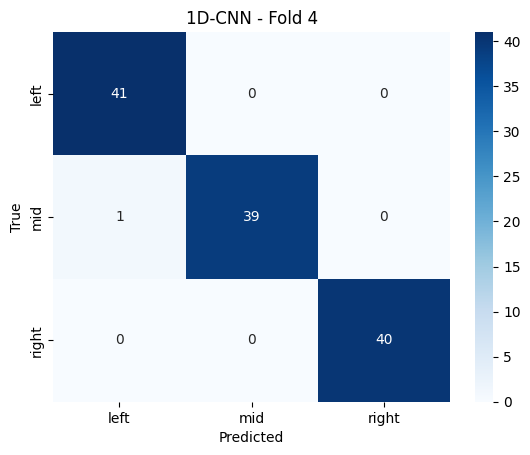


🔁 1D-CNN - Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


✅ Accuracy: 0.9587
              precision    recall  f1-score   support

        left       0.91      1.00      0.95        41
         mid       0.97      0.90      0.94        40
       right       1.00      0.97      0.99        40

    accuracy                           0.96       121
   macro avg       0.96      0.96      0.96       121
weighted avg       0.96      0.96      0.96       121



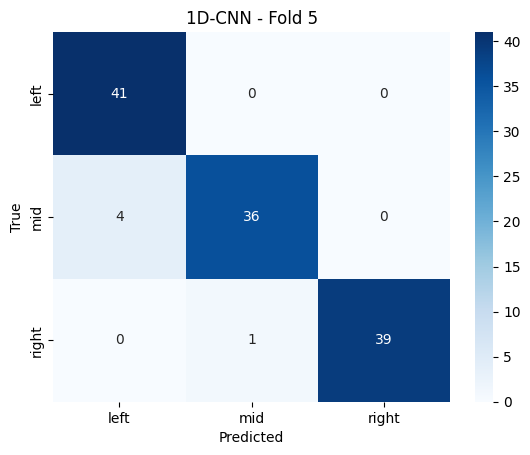


📊 1D-CNN Avg Accuracy: 0.9802

🔁 Random Forest - Fold 1
✅ Accuracy: 1.0000
              precision    recall  f1-score   support

        left       1.00      1.00      1.00        41
         mid       1.00      1.00      1.00        40
       right       1.00      1.00      1.00        41

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122



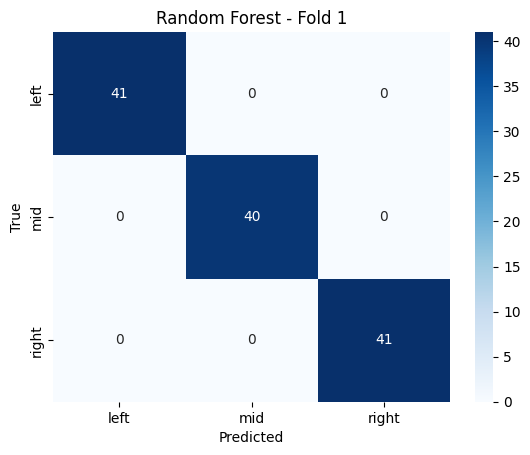


🔁 Random Forest - Fold 2
✅ Accuracy: 0.9754
              precision    recall  f1-score   support

        left       0.98      0.98      0.98        41
         mid       0.97      0.95      0.96        40
       right       0.98      1.00      0.99        41

    accuracy                           0.98       122
   macro avg       0.98      0.98      0.98       122
weighted avg       0.98      0.98      0.98       122



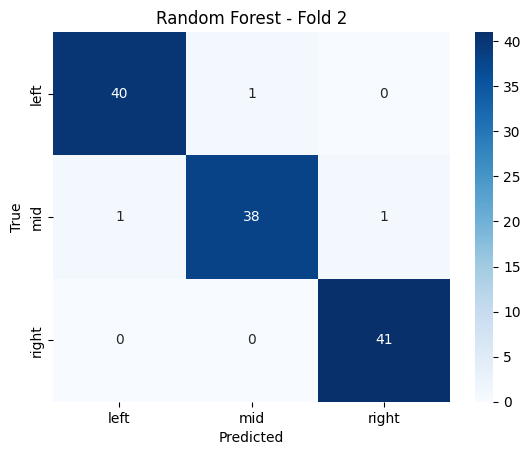


🔁 Random Forest - Fold 3
✅ Accuracy: 0.9669
              precision    recall  f1-score   support

        left       0.97      0.95      0.96        41
         mid       0.95      0.95      0.95        39
       right       0.98      1.00      0.99        41

    accuracy                           0.97       121
   macro avg       0.97      0.97      0.97       121
weighted avg       0.97      0.97      0.97       121



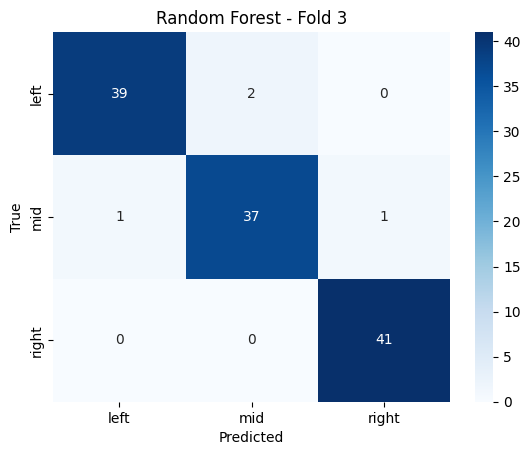


🔁 Random Forest - Fold 4
✅ Accuracy: 0.9917
              precision    recall  f1-score   support

        left       0.98      1.00      0.99        41
         mid       1.00      0.97      0.99        40
       right       1.00      1.00      1.00        40

    accuracy                           0.99       121
   macro avg       0.99      0.99      0.99       121
weighted avg       0.99      0.99      0.99       121



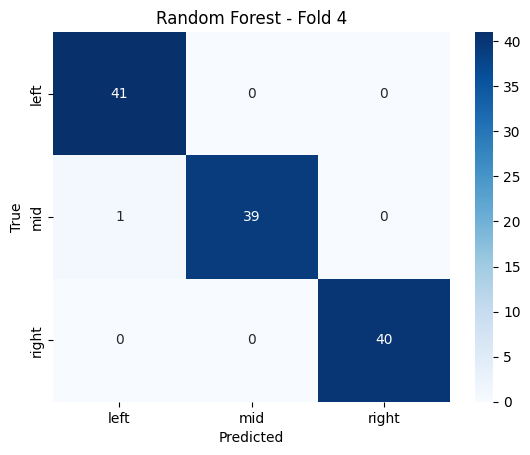


🔁 Random Forest - Fold 5
✅ Accuracy: 0.9504
              precision    recall  f1-score   support

        left       0.89      0.98      0.93        41
         mid       0.97      0.88      0.92        40
       right       1.00      1.00      1.00        40

    accuracy                           0.95       121
   macro avg       0.95      0.95      0.95       121
weighted avg       0.95      0.95      0.95       121



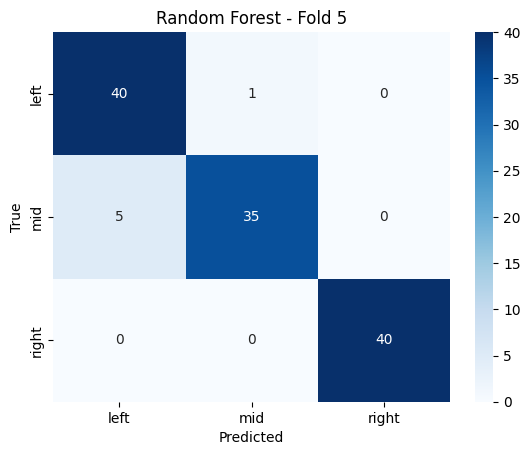


📊 Random Forest Avg Accuracy: 0.9769


In [ ]:
train_and_evaluate_model(build_lstm_model, "LSTM", X, y_onehot)
train_and_evaluate_model(build_cnn_model, "1D-CNN", X, y_onehot)
train_and_evaluate_model(lambda: RandomForestClassifier(n_estimators=100),
                         "Random Forest", X_rf, y_encoded, use_onehot=False)


In [ ]:
def test_all_models_on_folder(
    test_dir,
    lstm_model_path,
    cnn_model_path,
    rf_model_path,
    save_csv=False,
    output_path="all_model_predictions.csv"
):
    lstm_model = load_model(lstm_model_path)
    cnn_model = load_model(cnn_model_path)
    rf_model = joblib.load(rf_model_path)

    results = []

    for file in os.listdir(test_dir):
        if file.endswith(".csv"):
            file_path = os.path.join(test_dir, file)
            df = pd.read_csv(file_path)[FEATURES]

            # Pad or trim
            if len(df) < MAX_ROWS:
                pad = pd.DataFrame(np.zeros((MAX_ROWS - len(df), len(FEATURES))), columns=FEATURES)
                df = pd.concat([df, pad], ignore_index=True)
            else:
                df = df.iloc[:MAX_ROWS]

            df_scaled = StandardScaler().fit_transform(df)
            lstm_input = np.expand_dims(df_scaled, axis=0)
            cnn_input = np.expand_dims(df_scaled, axis=0)
            rf_input = df_scaled.reshape(1, -1)

            # Predictions
            lstm_pred = np.argmax(lstm_model.predict(lstm_input, verbose=0), axis=1)
            cnn_pred = np.argmax(cnn_model.predict(cnn_input, verbose=0), axis=1)
            rf_pred = rf_model.predict(rf_input)

            lstm_label = label_encoder.inverse_transform(lstm_pred)[0]
            cnn_label = label_encoder.inverse_transform(cnn_pred)[0]
            rf_label = label_encoder.inverse_transform(rf_pred)[0]

            results.append((file, lstm_label, cnn_label, rf_label))
            print(f"{file} ➜ LSTM: {lstm_label}, CNN: {cnn_label}, RF: {rf_label}")

    if save_csv:
        df_results = pd.DataFrame(results, columns=["File", "LSTM", "CNN", "RandomForest"])
        df_results.to_csv(output_path, index=False)
        print(f"\n✅ Saved results to {output_path}")


In [ ]:
test_all_models_on_folder(
    test_dir="/content/drive/MyDrive/test_2",
    lstm_model_path="lstm_fold1.h5",
    cnn_model_path="1d-cnn_fold1.h5",
    rf_model_path="random_forest_fold1.joblib",
    save_csv=True,
    output_path="test_results_all_models_fold1.csv"
)


right_1.csv ➜ LSTM: right, CNN: right, RF: right
right_2.csv ➜ LSTM: right, CNN: right, RF: right
right_3.csv ➜ LSTM: right, CNN: right, RF: right
right_4.csv ➜ LSTM: right, CNN: right, RF: right
right_5.csv ➜ LSTM: right, CNN: right, RF: right
right_6.csv ➜ LSTM: right, CNN: right, RF: right
right_7.csv ➜ LSTM: right, CNN: right, RF: right
right_8.csv ➜ LSTM: right, CNN: right, RF: right
right_9.csv ➜ LSTM: right, CNN: right, RF: mid
right_10.csv ➜ LSTM: right, CNN: right, RF: right
right_11.csv ➜ LSTM: right, CNN: right, RF: right
right_12.csv ➜ LSTM: right, CNN: right, RF: right
right_13.csv ➜ LSTM: right, CNN: right, RF: right
right_14.csv ➜ LSTM: right, CNN: right, RF: right
right_15.csv ➜ LSTM: right, CNN: right, RF: right
left_1.csv ➜ LSTM: mid, CNN: mid, RF: mid
left_2.csv ➜ LSTM: left, CNN: left, RF: left
left_3.csv ➜ LSTM: mid, CNN: left, RF: left
left_4.csv ➜ LSTM: left, CNN: left, RF: left
left_5.csv ➜ LSTM: left, CNN: left, RF: left
left_6.csv ➜ LSTM: left, CNN: left, RF: 

In [ ]:
test_all_models_on_folder(
    test_dir="/content/drive/MyDrive/test_4",
    lstm_model_path="lstm_fold1.h5",
    cnn_model_path="1d-cnn_fold1.h5",
    rf_model_path="random_forest_fold1.joblib",
    save_csv=True,
    output_path="test_results_all_models_r3_fold1.csv"
)

Left_13.csv ➜ LSTM: mid, CNN: left, RF: left
Left_12.csv ➜ LSTM: left, CNN: left, RF: left
Left_11.csv ➜ LSTM: left, CNN: left, RF: left
Left_5.csv ➜ LSTM: left, CNN: left, RF: left
Left_7.csv ➜ LSTM: left, CNN: left, RF: left
Left_9.csv ➜ LSTM: mid, CNN: left, RF: left
Left_8.csv ➜ LSTM: left, CNN: left, RF: left
Left_6.csv ➜ LSTM: left, CNN: left, RF: left
Left_4.csv ➜ LSTM: left, CNN: left, RF: left
Right_54.csv ➜ LSTM: right, CNN: right, RF: right
Right_51.csv ➜ LSTM: right, CNN: right, RF: right
Right_52.csv ➜ LSTM: right, CNN: right, RF: right
Right_53.csv ➜ LSTM: right, CNN: right, RF: right
Left_2.csv ➜ LSTM: mid, CNN: left, RF: left
Left_3.csv ➜ LSTM: left, CNN: left, RF: left
Right_50.csv ➜ LSTM: right, CNN: right, RF: right
Left_1.csv ➜ LSTM: left, CNN: left, RF: left
Left_10.csv ➜ LSTM: left, CNN: left, RF: left
Right_49.csv ➜ LSTM: right, CNN: right, RF: right
Right_55.csv ➜ LSTM: right, CNN: right, RF: right
Right_46.csv ➜ LSTM: right, CNN: right, RF: right
Right_44.csv ➜

## Training and Testing Random Forest model on whole dataset (450 samples)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_rf, y_encoded)
joblib.dump(rf_model, "random_forest_final.joblib")

['random_forest_final.joblib']

In [ ]:
def predict_folder_csvs(folder_path, model_path, model_type='lstm', save_csv=False, output_csv='predictions.csv'):
    from tensorflow.keras.models import load_model

    results = []

    if model_type == 'rf':
        model = joblib.load(model_path)
    else:
        model = load_model(model_path)

    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)[FEATURES]

            # Pad or trim
            if len(df) < MAX_ROWS:
                pad = pd.DataFrame(np.zeros((MAX_ROWS - len(df), len(FEATURES))), columns=FEATURES)
                df = pd.concat([df, pad], ignore_index=True)
            else:
                df = df.iloc[:MAX_ROWS]

            df_scaled = StandardScaler().fit_transform(df)

            if model_type == 'rf':
                X_input = df_scaled.reshape(1, -1)
                pred = model.predict(X_input)
            else:
                X_input = np.expand_dims(df_scaled, axis=0)
                pred = np.argmax(model.predict(X_input, verbose=0), axis=1)

            label = label_encoder.inverse_transform(pred)[0]
            print(f"{file} ➜ {label}")
            results.append((file, label))

    if save_csv:
        pd.DataFrame(results, columns=["File", "Predicted"]).to_csv(output_csv, index=False)
        print(f"\n✅ Saved predictions to {output_csv}")

    return results


In [ ]:
predict_folder_csvs(
    folder_path="/content/drive/MyDrive/test_5",
    model_path="random_forest_final.joblib",     # or "1d-cnn_final.h5", or "random_forest_final.joblib"
    model_type="rf",              # or "rf"
    save_csv=True,
    output_csv="test_results.csv"
)


Left_33.csv ➜ left
Left_32.csv ➜ left
Left_34.csv ➜ left
Left_23.csv ➜ left
Left_16.csv ➜ left
Left_15.csv ➜ left
Left_18.csv ➜ left
Right_1.csv ➜ right
Right_2.csv ➜ right
Right_3.csv ➜ right
Right_4.csv ➜ right
Right_5.csv ➜ right
Right_6.csv ➜ right
Right_7.csv ➜ right
Right_8.csv ➜ right
Right_9.csv ➜ right
Right_10.csv ➜ right
Right_11.csv ➜ right
Right_12.csv ➜ right
Right_13.csv ➜ right
Right_14.csv ➜ right
Right_15.csv ➜ right
Right_16.csv ➜ right
Right_17.csv ➜ right
Right_18.csv ➜ right
Right_19.csv ➜ right
Right_20.csv ➜ right
Right_21.csv ➜ right
Right_22.csv ➜ right
Right_23.csv ➜ right
Right_24.csv ➜ right
Right_25.csv ➜ right
Right_26.csv ➜ right
Right_27.csv ➜ right
Right_28.csv ➜ right
Right_29.csv ➜ right
Right_30.csv ➜ right
Right_31.csv ➜ right
Right_32.csv ➜ right
Right_33.csv ➜ right
Right_34.csv ➜ right
Right_35.csv ➜ right
Right_36.csv ➜ right
Right_37.csv ➜ right
Right_38.csv ➜ right
Right_39.csv ➜ right
Right_40.csv ➜ right
Right_41.csv ➜ right
Right_42.csv ➜ 

[('Left_33.csv', np.str_('left')),
 ('Left_32.csv', np.str_('left')),
 ('Left_34.csv', np.str_('left')),
 ('Left_23.csv', np.str_('left')),
 ('Left_16.csv', np.str_('left')),
 ('Left_15.csv', np.str_('left')),
 ('Left_18.csv', np.str_('left')),
 ('Right_1.csv', np.str_('right')),
 ('Right_2.csv', np.str_('right')),
 ('Right_3.csv', np.str_('right')),
 ('Right_4.csv', np.str_('right')),
 ('Right_5.csv', np.str_('right')),
 ('Right_6.csv', np.str_('right')),
 ('Right_7.csv', np.str_('right')),
 ('Right_8.csv', np.str_('right')),
 ('Right_9.csv', np.str_('right')),
 ('Right_10.csv', np.str_('right')),
 ('Right_11.csv', np.str_('right')),
 ('Right_12.csv', np.str_('right')),
 ('Right_13.csv', np.str_('right')),
 ('Right_14.csv', np.str_('right')),
 ('Right_15.csv', np.str_('right')),
 ('Right_16.csv', np.str_('right')),
 ('Right_17.csv', np.str_('right')),
 ('Right_18.csv', np.str_('right')),
 ('Right_19.csv', np.str_('right')),
 ('Right_20.csv', np.str_('right')),
 ('Right_21.csv', np.str

## Making LSTM model on whole dataset (600 samples)

In [ ]:
model = build_lstm_model(X.shape[1:], y_onehot.shape[1])
model.fit(X, y_onehot, epochs=30, batch_size=32, validation_split=0.1, verbose=1)
model.save("lstm_final.h5")

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.4116 - loss: 1.0597 - val_accuracy: 0.0492 - val_loss: 1.0352
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.7357 - loss: 0.7229 - val_accuracy: 0.1311 - val_loss: 1.0520
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.8348 - loss: 0.4156 - val_accuracy: 0.5574 - val_loss: 0.8187
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9048 - loss: 0.3055 - val_accuracy: 0.1639 - val_loss: 1.6412
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9184 - loss: 0.2552 - val_accuracy: 0.7049 - val_loss: 0.7374
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9640 - loss: 0.1321 - val_accuracy: 0.7377 - val_loss: 0.6102
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.9818 - loss: 0.0852 - val_accuracy: 0.9508 - val_loss: 0.2025
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9776 - loss: 0.0869 - val_accuracy: 0.6557 - val_

In [ ]:
predict_folder_csvs(
    folder_path="/content/drive/MyDrive/test_2",
    model_path="lstm_final.h5",     # or "1d-cnn_final.h5", or "random_forest_final.joblib"
    model_type="lstm",              # or "rf"
    save_csv=True,
    output_csv="test_results.csv"
)


right_1.csv ➜ right
right_2.csv ➜ right
right_3.csv ➜ right
right_4.csv ➜ right
right_5.csv ➜ right
right_6.csv ➜ right
right_7.csv ➜ right
right_8.csv ➜ right
right_9.csv ➜ right
right_10.csv ➜ right
right_11.csv ➜ right
right_12.csv ➜ right
right_13.csv ➜ right
right_14.csv ➜ right
right_15.csv ➜ right
left_1.csv ➜ left
left_2.csv ➜ left
left_3.csv ➜ left
left_4.csv ➜ left
left_5.csv ➜ left
left_6.csv ➜ left
left_7.csv ➜ left
left_8.csv ➜ left
left_9.csv ➜ left
left_10.csv ➜ left
left_11.csv ➜ left
left_12.csv ➜ left
left_13.csv ➜ left
left_14.csv ➜ left
left_15.csv ➜ left
left_16.csv ➜ left
left_17.csv ➜ left
mid_1.csv ➜ mid
mid_2.csv ➜ mid
mid_3.csv ➜ left
mid_4.csv ➜ mid
mid_5.csv ➜ mid
mid_6.csv ➜ mid
mid_7.csv ➜ left
mid_8.csv ➜ left
mid_9.csv ➜ left
mid_10.csv ➜ left
mid_11.csv ➜ left
mid_12.csv ➜ mid
mid_13.csv ➜ mid
mid_14.csv ➜ left
mid_15.csv ➜ mid
mid_16.csv ➜ mid
mid_17.csv ➜ left
mid_18.csv ➜ left
mid_19.csv ➜ mid
mid_20.csv ➜ left
mid_21.csv ➜ mid
mid_22.csv ➜ mid
mid_2

[('right_1.csv', np.str_('right')),
 ('right_2.csv', np.str_('right')),
 ('right_3.csv', np.str_('right')),
 ('right_4.csv', np.str_('right')),
 ('right_5.csv', np.str_('right')),
 ('right_6.csv', np.str_('right')),
 ('right_7.csv', np.str_('right')),
 ('right_8.csv', np.str_('right')),
 ('right_9.csv', np.str_('right')),
 ('right_10.csv', np.str_('right')),
 ('right_11.csv', np.str_('right')),
 ('right_12.csv', np.str_('right')),
 ('right_13.csv', np.str_('right')),
 ('right_14.csv', np.str_('right')),
 ('right_15.csv', np.str_('right')),
 ('left_1.csv', np.str_('left')),
 ('left_2.csv', np.str_('left')),
 ('left_3.csv', np.str_('left')),
 ('left_4.csv', np.str_('left')),
 ('left_5.csv', np.str_('left')),
 ('left_6.csv', np.str_('left')),
 ('left_7.csv', np.str_('left')),
 ('left_8.csv', np.str_('left')),
 ('left_9.csv', np.str_('left')),
 ('left_10.csv', np.str_('left')),
 ('left_11.csv', np.str_('left')),
 ('left_12.csv', np.str_('left')),
 ('left_13.csv', np.str_('left')),
 ('left_

In [ ]:
cnn_model = build_cnn_model(X.shape[1:], y_onehot.shape[1])
cnn_model.fit(X, y_onehot, epochs=30, batch_size=32, validation_split=0.1, verbose=1)
cnn_model.save("1d-cnn_final.h5")

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.6367 - loss: 0.7584 - val_accuracy: 0.4098 - val_loss: 0.7794
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8947 - loss: 0.2586 - val_accuracy: 0.4918 - val_loss: 0.7921
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9386 - loss: 0.1540 - val_accuracy: 0.9344 - val_loss: 0.2744
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9387 - loss: 0.1684 - val_accuracy: 0.9508 - val_loss: 0.2764
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9640 - loss: 0.0966 - val_accuracy: 0.9508 - val_loss: 0.2303
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9805 - loss: 0.0634 - val_accuracy: 0.9344 - val_loss: 0.2651
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9861 - loss: 0.0550 - val_accuracy: 0.9344 - val_loss: 0.2116
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9823 - loss: 0.0463 - val_accuracy: 0.9344 - val_loss: 0.

In [ ]:
predict_folder_csvs(
    folder_path="/content/drive/MyDrive/test_2",
    model_path="1d-cnn_final.h5",     # or "1d-cnn_final.h5", or "random_forest_final.joblib"
    model_type="lstm",              # or "rf"
    save_csv=True,
    output_csv="test_results.csv"
)


right_1.csv ➜ right
right_2.csv ➜ right
right_3.csv ➜ right
right_4.csv ➜ right
right_5.csv ➜ right
right_6.csv ➜ right
right_7.csv ➜ right
right_8.csv ➜ right
right_9.csv ➜ right
right_10.csv ➜ right
right_11.csv ➜ right
right_12.csv ➜ right
right_13.csv ➜ right
right_14.csv ➜ right
right_15.csv ➜ right
left_1.csv ➜ mid
left_2.csv ➜ left
left_3.csv ➜ left
left_4.csv ➜ left
left_5.csv ➜ left
left_6.csv ➜ left
left_7.csv ➜ left
left_8.csv ➜ left
left_9.csv ➜ left
left_10.csv ➜ left
left_11.csv ➜ left
left_12.csv ➜ left
left_13.csv ➜ left
left_14.csv ➜ left
left_15.csv ➜ left
left_16.csv ➜ left
left_17.csv ➜ left
mid_1.csv ➜ mid
mid_2.csv ➜ mid
mid_3.csv ➜ mid
mid_4.csv ➜ mid
mid_5.csv ➜ mid
mid_6.csv ➜ left
mid_7.csv ➜ left
mid_8.csv ➜ left
mid_9.csv ➜ left
mid_10.csv ➜ mid
mid_11.csv ➜ left
mid_12.csv ➜ left
mid_13.csv ➜ mid
mid_14.csv ➜ left
mid_15.csv ➜ left
mid_16.csv ➜ mid
mid_17.csv ➜ left
mid_18.csv ➜ left
mid_19.csv ➜ mid
mid_20.csv ➜ left
mid_21.csv ➜ mid
mid_22.csv ➜ mid
mid_2

[('right_1.csv', np.str_('right')),
 ('right_2.csv', np.str_('right')),
 ('right_3.csv', np.str_('right')),
 ('right_4.csv', np.str_('right')),
 ('right_5.csv', np.str_('right')),
 ('right_6.csv', np.str_('right')),
 ('right_7.csv', np.str_('right')),
 ('right_8.csv', np.str_('right')),
 ('right_9.csv', np.str_('right')),
 ('right_10.csv', np.str_('right')),
 ('right_11.csv', np.str_('right')),
 ('right_12.csv', np.str_('right')),
 ('right_13.csv', np.str_('right')),
 ('right_14.csv', np.str_('right')),
 ('right_15.csv', np.str_('right')),
 ('left_1.csv', np.str_('mid')),
 ('left_2.csv', np.str_('left')),
 ('left_3.csv', np.str_('left')),
 ('left_4.csv', np.str_('left')),
 ('left_5.csv', np.str_('left')),
 ('left_6.csv', np.str_('left')),
 ('left_7.csv', np.str_('left')),
 ('left_8.csv', np.str_('left')),
 ('left_9.csv', np.str_('left')),
 ('left_10.csv', np.str_('left')),
 ('left_11.csv', np.str_('left')),
 ('left_12.csv', np.str_('left')),
 ('left_13.csv', np.str_('left')),
 ('left_1

### For now using 1D-CNN model for the game